
# CMPE561: Natural Language Processing
# Assignment 1: Authorship Recognition using Naive Bayes

**Name:** Doruk Kilitçioğlu  
**Student ID:** 2012400183
## 1. Introduction
This assignment was challenging, yet straightforward to implement. By the time I had finished with everything except the extra feature sets, I felt quite pleased at having implemented much of the assignment. But then, I attempted some extra feature sets, and failed spectacularly. That failure by itself made me learn of the differences between a Naive Bayes classifier, a Multinomial Naive Bayes classifier, and the bag of words feature set. I had to go back and reimplement most of my classifier codes, but in the end, I feel very much on top of things, more so than I would have been have I without my failure. The code and the report in Jupyter Notebook format can be found at [GitHub](https://github.com/Xyllan/nlp_assignment_1).

Below are the incremental steps I have taken during the assignment.
## 2. Preprocessing
The preprocessing phase is quite simple. Given one input directory (the dataset) and two output directories (training and test directories), I collect the files from the author folders, shuffle them using Fisher-Yates shuffle, copy the first 60% into the training directory and the last 40% to the test directory. The preprocessor can be run by calling

    ./preprocessor.py path/to/dataset path/to/training/set path/to/test/set

Since the code is object oriented, the same can be achieved by creating a Preprocessor object and calling the relevant functions.


In [2]:
from preprocessor import Preprocessor
p = Preprocessor()
seed = 1234
tra, tes = p.organize_dataset(seed, '69yazar/raw_texts', training_path = '69yazar/raw_texts__training',
                              test_path = '69yazar/raw_texts__test')
print('Training directory path:',tra)
print('Test directory path:',tes)

Training directory path: 69yazar/raw_texts__training
Test directory path: 69yazar/raw_texts__test


The preprocessor keeps track of the files in training and test datasets. The generated training and test datasets as follows:

In [3]:
p.organize_authors(tra, tes)
authors = p.get_authors()
for author in authors:
    print('Class:',author, '('+str(len(p.training_data(author))) + ' training',
          str(len(p.test_data(author)))+' test)')

Class: ruhatMengi (9 training 6 test)
Class: emreAkoz (18 training 12 test)
Class: hasmetBabaoglu (6 training 4 test)
Class: nurayMert (6 training 4 test)
Class: huseyinGulerce (6 training 4 test)
Class: mehmetTezkan (6 training 4 test)
Class: hasanPulur (6 training 4 test)
Class: omerUrundul (6 training 4 test)
Class: hincalUluc (6 training 4 test)
Class: fikretBila (6 training 4 test)
Class: melihAsik (6 training 4 test)
Class: raufTamer (6 training 4 test)
Class: abdullahAymaz (6 training 4 test)
Class: bulentKorucu (6 training 4 test)
Class: mumtazerTurkone (6 training 4 test)
Class: gulseBirsel (6 training 4 test)
Class: doganHizlan (9 training 6 test)
Class: muratBardakci (6 training 4 test)
Class: cemSuer (6 training 4 test)
Class: muratBelge (6 training 4 test)
Class: ayseArman (9 training 6 test)
Class: deryaSazak (6 training 4 test)
Class: emreKongar (9 training 6 test)
Class: mehmetaliBirand (6 training 4 test)
Class: tahaAkyol (18 training 12 test)
Class: mahfiEgilmez (9 tr

## 3. Tokenizer

The tokenizer is quite basic. Given a filepath, it reads the file in the Windows-1254 encoding, splits it into sentences, and then splits the sentences into tokens. The sentence splitting is done by matching any of the $.!?:$ characters, with the exception of a dot preceded and followed by numbers (eg. 4.5). The sentence tokenizing employs a few basic rules:
* Match any non-whitespace character sequences.
* Remove any surrounding punctuation marks.
* If there is an apostrophe, remove apostrophe and the characters to its left.
* If all characters are uppercase, keep it uppercase, otherwise convert to lowercase.
* If token is part of a list of stopwords, discard token.

There are four different use methods for the Tokenizer:
1. Token stream through has_next() and next_token() methods (as is customary).
2. List of all word tokens through bag_of_words() method.
3. List of all character n-grams through bag_of_char_ngrams() method.
4. List of features through features() method.

I have not chosen to employ a stemmer or a POS-tagger. The most widely known Turkish stemmer and POS-tagger is Zemberek-NLP, which is written in Java and it would've been a pain to write a Python wrapper to it, for minimal gain. The features generated by the tokenizer will be explained in the extra feature set section.

The stopword list is taken from [Türkçe Öğretimi](http://www.turkceogretimi.com/Genel-Konular/article/541-turkce-etkisiz-kelimeler-stop-words-listesi-11/35).

In [4]:
from tokenizer import Tokenizer
t = Tokenizer(p.file_path('ridvanDilmen', p.training_data('ridvanDilmen')[0]))
print('Original:\n')
print(t.original[0:200],'...')
print('\nSentences:')
print(t.sentences[0:3])

Original:

El freni Rijkaard...
 
 Siz Elano’yu, Arda’yı, Nonda’yı çıkarırsanız nasıl öne oynayabilirsiniz. Ayhan ile ileri gidebilir misiniz?
 
 Önce Beşiktaş berabere kalmış, ardından Fenerbahçe yenilmiş. Kötü ...

Sentences:
['El freni Rijkaard', 'Siz Elano’yu, Arda’yı, Nonda’yı çıkarırsanız nasıl öne oynayabilirsiniz', 'Ayhan ile ileri gidebilir misiniz']


It is easy to use the bag of words..

In [5]:
bag = t.bag_of_words()
print('Unique words:',len(bag))
print('# occurences of \'arda\':',bag['arda'])

Unique words: 189
# occurences of 'arda': 3


.. and the bag of character n-grams.

In [6]:
bag = t.bag_of_char_ngrams(6)
print('Unique n-grams:',len(bag))
print('# of occurences of \'tasara\':', bag['tasara'])

Unique n-grams: 361
# of occurences of 'tasara': 5


The bag of words representations of token lists are easily produced using the Counter class in Python collections library.
## 4. Naive Bayes Classifier
There are 3 different Naive Bayes classifiers included in the project. All of them are vectorized with NumPy. One is the Multinomial Naive Bayes implementation, that is used alongside the bag of words and bag of character n-grams feature sets. Other is the Binarized Multinomial Naive Bayes classifier, which the set of words feature set. Note that by taking $min(1,feature\ counts)$ on the vectorized bag of words, we get a set of words representation.

These classifiers first amass the features and feature counts of each class. From there, a unique list of features is constructed (a vocabulary in the bag of words case). These features are then vectorized and the log probabilities of all features are computed, including the probability of an unknown/non-occuring feature. This vectorization does lead to a very sparse matrix of classes and features, but leads to a more generic Multinomial Naive Bayes implementation, decoupled from the bag of words feature set.

In [7]:
from naive_bayes import MultinomialNaiveBayes
from collections import Counter
bayes = MultinomialNaiveBayes(['china','japan'])
china = 'Chinese Beijing Chinese Chinese Chinese Shanghai Chinese Macao'.split(' ')
japan = 'Tokyo Japan Chinese'.split(' ')
bayes.add_documents('china', amount = 3)
bayes.add_documents('japan', amount = 1)
bayes.add_feature_counts('china', Counter(china))
bayes.add_feature_counts('japan', Counter(japan))
bayes.train()
s = 'Chinese Chinese Chinese Japan Tokyo Adelaide Macao'
print('Guessing:',s)
v = bayes.vectorize(Counter(s.split(' ')))
print('Vector representation:',v)
print('Predicted class:',bayes.most_probable_class(v))

Guessing: Chinese Chinese Chinese Japan Tokyo Adelaide Macao
Vector representation: [1 1 0 1 0 3 1]
Predicted class: china


The unknown words are represented by the last index of the feature vector.

In most cases, the multiple appearances of a word is immaterial; this will be confirmed in the results section.

In [8]:
from naive_bayes import BinarizedMultinomialNaiveBayes
bbayes = BinarizedMultinomialNaiveBayes(['china','japan'])
bbayes.add_documents('china', amount = 3)
bbayes.add_documents('japan', amount = 1)
bbayes.add_feature_counts('china', Counter(china))
bbayes.add_feature_counts('japan', Counter(japan))
bbayes.train()
print('Guessing:',s)
v = bbayes.vectorize(Counter(s.split(' ')))
print('Vector representation:',v)
print('Predicted class:',bbayes.most_probable_class(v))

Guessing: Chinese Chinese Chinese Japan Tokyo Adelaide Macao
Vector representation: [1 1 0 1 0 1 1]
Predicted class: japan


The last one is Normalizing Naive Bayes classifier, which tries to fit features into normal distributions. The probability of a feature given a class then becomes the probability density of that feature for each occurance. It is mainly made use for the complexity features.
## 5. Extra Feature Sets
I have chosen 3 different extra feature sets to implement. The bag of character n-grams was mentioned in the assignment description, which work similar to the bag of words. The set of words feature set is essentially bag of words applied to the Binarized Multinomial Naive Bayes classifier. It does work surprisingly well, as will be apparent in the results section. The third feature set is completixy features. I have employed the following complexity features in my feature set:
* Number of sentences in a document
* Average number of words in a sentence
* Average word length
* Average number of commas in a sentence
* Average number of exclamation marks in a sentence
* Average number of question marks in a sentence
* Average number of periods in a sentence
* Average number of unique words per word

Unfortunately, these complexity features were a poor fit to normal distributions, as will be discussed in the results section.
## 6. Tester
The tester trains the naive bayes implementations, tests with the test data, and calculates the related scores. A confusion matrix is built from the test data, which is then used to calculate various scores. The $test\_authors()$ method of the tester constructs the testing environment for all feature sets. Note that the calculation takes 1-2 minutes if all feature sets are enabled.

The test set can be called from the command prompt by

    ./tester.py path/to/training/set path/to/test/set
    
which will print to the console the micro and macro averaged precision, recall, and f-score values of the bag of words feature set and the bag of character n-grams feature set. Here, we will report scores of all extra feature sets.

In [9]:
import tester
import numpy as np
scores = ()
with np.errstate(divide='ignore', invalid='ignore'):
    scores = tester.test_authors(p, bag_of_words = True, alpha = 0.05, print_predictions = False,
                      bag_of_char_ngrams = True, ngram_len = 5, set_of_words = True, complexity_features = True)
print('Bag of words scores:')
tester.print_scores(scores[0])

Bag of words scores:
Micro-averaged scores:
Precision: 0.684065934066
Recall: 0.684065934066
F-score (beta=1): 0.684065934066
Macro-averaged scores:
Precision: 0.730798123445
Recall: 0.623188405797
F-score (beta=1): 0.672717058366


## 7. Results

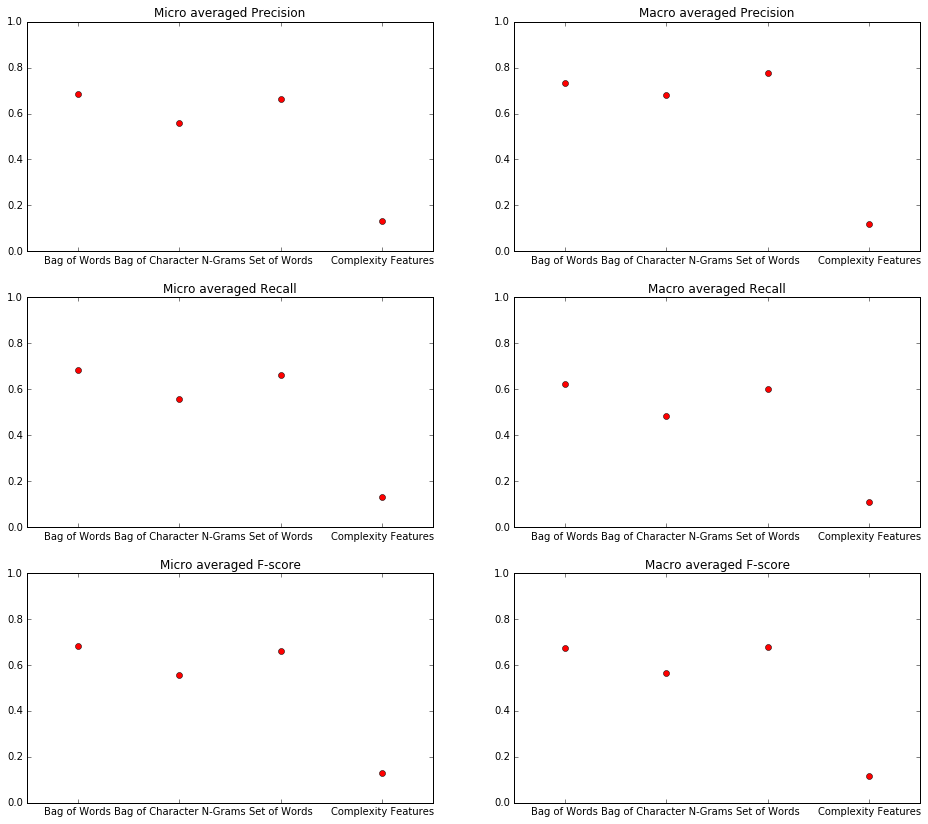

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
features = ['Bag of Words', 'Bag of Character N-Grams', 'Set of Words', 'Complexity Features']
score_v = np.array(scores)
fig, ax = plt.subplots(3, 2, figsize=(16, 14))
mm = ['Micro averaged','Macro averaged']
ss = ['Precision','Recall','F-score']
plt.setp(ax, xticks=[0,1,2,3], xticklabels=features)
for col in range(2):
    for row in range(3):
        ax[row,col].plot(np.array(range(4)), score_v[:,col*3+row], 'ro')
        ax[row,col].axis([-0.5, 3.5, 0, 1])
        ax[row,col].set_title(mm[col]+' '+ss[row])

In [11]:
tester.print_multiple_scores(scores)

Scores for the Bag of Words feature set:
Micro-averaged scores:
Precision: 0.684065934066
Recall: 0.684065934066
F-score (beta=1): 0.684065934066
Macro-averaged scores:
Precision: 0.730798123445
Recall: 0.623188405797
F-score (beta=1): 0.672717058366


Scores for the Bag of Character N-Grams feature set:
Micro-averaged scores:
Precision: 0.557692307692
Recall: 0.557692307692
F-score (beta=1): 0.557692307692
Macro-averaged scores:
Precision: 0.679824409367
Recall: 0.481884057971
F-score (beta=1): 0.563990974163


Scores for the Set of Words feature set:
Micro-averaged scores:
Precision: 0.662087912088
Recall: 0.662087912088
F-score (beta=1): 0.662087912088
Macro-averaged scores:
Precision: 0.775303280948
Recall: 0.601449275362
F-score (beta=1): 0.677399281919


Scores for the Complexity Features feature set:
Micro-averaged scores:
Precision: 0.131868131868
Recall: 0.131868131868
F-score (beta=1): 0.131868131868
Macro-averaged scores:
Precision: 0.118331811163
Recall: 0.111111111111
F-sc

We can see that the Bag of Words feature set gets the highest micro averaged precision, recall, and f-scores, while the set of words feature set does get the highest macro averaged precision and f-scores. The fact that we are ignoring most of the frequency aspect of the bag of words and still getting high results confirm the suspicion that when a word has appeared once, it is likely to appear again, and hence the frequency aspect is overrated.

The character n-grams performed a tid bit worse, with f-scores around 0.56 to bag of words' 0.68. The choice of *n* did not seem to matter as long as it was not too large, where the data becomes too sparse to classify correctly.

The bad performance of the complexity features feature set suggest that either our feature set was inadequate, or that normal distributions were not a good fit for our selection of features. Given that the standard deviations of the features are relatively high, the inability to fit adequately is not much of a surprise. And since I did not employ any POS-tagging, I am missing large portion of the available features.

One thing of note is how much our selection of the Laplace smoothing parameter $\alpha$ changes our results. With $\alpha=1$, the bag of words f-scores were around 0.35. After setting $\alpha=0.05$, the results skyrocketed. This is most probably due to the relative smallness of our training data. When working with English data on classes like *positive* or *economy*, there are abundant sources of annotated data. By reducing $\alpha$, we are compensating for our lack of data.

In the end, the second best feature set we have is the set of words feature set, with character n-grams trailing close behind. Perhaps the complexity features are best explored at another time, with the POS-tagging in my feature set.